# Parameter Estimation (and Hypothesis testing... which is just parameter estimation)

In our `MagicCoin` example `n` was an example of a parameter. It's some important value for our understanding of how things work that we don't know. By using probability and data we can come up with ways to estimate what these parameters might be.

In the rest of this tutorial we'll focus on an admittedly boring case of trying to estimate the rate that a product sells. The rate being the parameter we're trying to estimate.

We'll be using a simulated product and customer data...

In [7]:
from context import src
from src import customer as cust
from src import product as prod
from src import experiment as exp


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

Let's start by creating a new product. Our `Product` class is amazingly simple. It just takes a `name`, a `price` and a `quality`. Of course `quality` of a product is not so easy, but in this case we can just set it to whatever we want to simulate the average reviews are.

We'll start with a toothbrush:

In [12]:
toothbrush = prod.Product(name="alright brush",
                          price=4.99,
                          quality=3.9)

It's not the most amazing toothbrush, but let's try to sell it to somebody. Our `Customer` class can generate a random customer for us that has a certain price threshold and quality threshold that we don't know, and varies from customer to customer:

In [22]:
person_a = cust.Customer.get_random()

Next we can show our customer the product using the `will_purchase` method and we'll get a bool back telling us whether or not the decided to purchase that product:

In [23]:
person_a.will_purchase(toothbrush)

array([ True])

Like the `MagicCoin` we don't really know what's going on inside of our customer. This singular observation doesn't tell us very much about how our coin behaves. The best way to hand this is to run some sort of `Experiment`!

We can create an experiment using our `Experiment` class which will help us collect data on customers that we've shown our `toothbrush` too!

In [25]:
toothbrush_test = exp.Experiment(toothbrush)

Now we can use our experiment to show this `toothbrush` to a bunch of customers and see how many will purchase it!

In [30]:
test_result = toothbrush_test.show_to_customers(20)

Now we can see how our test went...

In [43]:
test_result.purchased

0     [False]
1      [True]
2     [False]
3     [False]
4     [False]
5      [True]
6     [False]
7     [False]
8     [False]
9     [False]
10    [False]
11    [False]
12    [False]
13    [False]
14    [False]
15     [True]
16    [False]
17    [False]
18    [False]
19     [True]
Name: purchased, dtype: object

With the `MagicCoin` we understood exactly how it worked so we didn't need a model to represent how we think the `ModelCoin` worked.

Even though the interaction between the `Customer` and the `Product` is more complicated that simply a probability that a `Customer` will purchase a `Product` from our view the best way to model this is to make the simplifying assumption that each `Product` sells on at a particular rate.

If you've worked in ecommerce or any similar conversion focused industry it might seem obvious that we want to estimate "the rate that a product sells", but it's good to remember that this is really an application of probability. If we knew everything about each customer and each product and how they interact we would know exactly how a product sells, there would be no rate involved at all!

So if you wanted to estimate a rate at what this product sells, what would be your first estimate? Most people intuitively might estimate:

In [50]:
sold = sum(test_result.purchased)
total = len(test_result.purchased)
rate_est = sold/total
print("{0} sold out of {1} total so our estimate is {2}".format(sold,total,rate_est))

[4] sold out of 20 total so our estimate is [0.2]


Making our `rate_est` as `sold/total` seems like a pretty good idea. But how can we show this is the best estimate, and are there other good estimate?

For example what about `rate_est + 0.05` or  `rate_est - 0.05`? Are these good estimate? certainly they explain the data pretty well. How would we compare these estimates?

One way we can do this is to use the Binomial distribution. The Binomial distribution will tell us exactly how likely data would be given this was the rate of a product selling. Let's look at the probability of the data for each of these alternate options:

In [51]:
bin_est = stats.binom(n=total,p=rate_est)
bin_est.pmf(sold)

array([0.2181994])

In [54]:
bin_est_bit_smaller = stats.binom(n=total,p=rate_est-0.05)
bin_est_bit_smaller.pmf(sold)

array([0.18212167])

In [55]:
bin_est_bit_bigger = stats.binom(n=total,p=rate_est+0.05)
bin_est_bit_bigger.pmf(sold)

array([0.18968545])

In both cases we can see that the slightly different estimates are a bit more surprised by the data that we observed. This means that they are not quite a good of an explaination of the data.. but that doesn't mean they're *wrong*.

If you flipped a coin 3 times and got 1 head, you wouldn't assume the probability of heads is $\frac{1}{3}$ the coin being fair is still pretty likely and you know that most coins tend to be fair so the belief that the probability of heads is $\frac{1}{2}$

Rather than just worry about which estimate for the rate is the best, it might be a good idea look at how strongly we believe in multi estimates. We could start by looking at esimates every 0.05 and apply the same logic using the Binomial Distribution we did before. We can use `numpy` to quickly do this in a vectorized way:

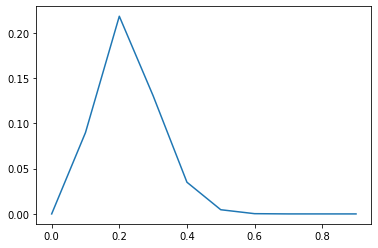

In [88]:
est_dists = stats.binom(total,np.arange(0,1,0.1))
sns.lineplot(x=np.arange(0,1,0.1),
              y=est_dists.pmf(sold))

Here we can see that if we look at each possibility between 0 and 1 incrementing by 0.05 we have some sort of distribution forming. 

We can see that this continues to smooth as we shrink our increment size:

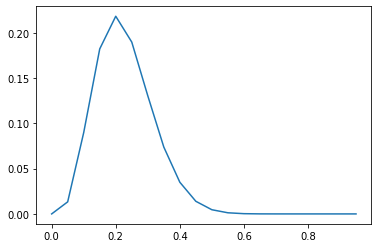

In [89]:
est_dists = stats.binom(total,np.arange(0,1,0.05))
sns.lineplot(x=np.arange(0,1,0.05),
              y=est_dists.pmf(sold))

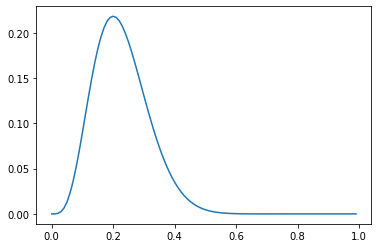

In [90]:
est_dists = stats.binom(total,np.arange(0,1,0.01))
sns.lineplot(x=np.arange(0,1,0.01),
              y=est_dists.pmf(sold))

### The Beta Distribution

The distribution we're converging on is a very useful distribution call the *Beta distribution*. It differs from our plot above in two ways: First it is a continous distribution meaning it accounts for the infinitely many possible rates for what we've observed. The second is that it makes it so that if we sum up over all those possible points (technically integrate) the result is exactly 1. This let's us talk about probabilities for different values. 

The Beta distribution takes two paramters $\alpha$ the number of successes or `True` values we oberved and $\beta$ the number failures or `False` values. Note that this I bit different than the Binomial where `n` = `alpha+beta`

Here's a plot of what this distribution looks like for our cases of `alpha = sold` and `beta = total - sold`

**note:** because the Beta distribution is continuous we'll use the `.pdf` method rather than the `.pmf` method.

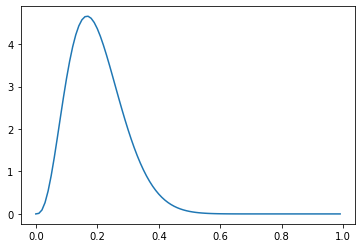

In [83]:
alpha = sold
beta = total - sold
est_beta_dist = stats.beta(alpha,beta)
xs = np.arange(0,1,0.01)
sns.lineplot(x=xs,
             y=est_beta_dist.pdf(xs))